In [1]:
import rasterio
from pathlib import Path
import matplotlib.pyplot as plt
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
from rasterio.plot import show
import numpy as np

# Tropo

Will have to install ARIA-Tools [here](https://github.com/aria-tools/ARIA-tools).

Relevant command is: `ariaTSsetup.py -f './products/Marrakesh-1_154_None_0911_noFr/S1*' -w out -l troposphereTotal -tm HRES -d Download`

Each stitched layer has it's own directory and they all share common geo-metadata.

In [2]:
tropo_dir = Path('out/troposphereTotal/HRES/')
tropo_vrts = sorted(list(tropo_dir.glob('*.vrt')), reverse=True)
tropo_vrts[:1]

[PosixPath('out/troposphereTotal/HRES/20230911_20230830.vrt')]

In [3]:
unw_dir = Path('out/unwrappedPhase/')
unw_vrts = sorted(list(unw_dir.glob('*.vrt')), reverse=True)
unw_vrts[:1]

[PosixPath('out/unwrappedPhase/20230911_20230830.vrt')]

In [4]:
iono_dir = Path('out/ionosphere')
iono_vrts = sorted(list(iono_dir.glob('*.vrt')), reverse=True)
iono_vrts[:1]

[PosixPath('out/ionosphere/20230911_20230830.vrt')]

In [5]:
set_dir = Path('out/solidEarthTide/')
set_vrts = sorted(list(set_dir.glob('*.vrt')), reverse=True)
set_vrts[:1]

[PosixPath('out/solidEarthTide/20230911_20230830.vrt')]

In [6]:
def open_one(vrt: Path) -> tuple:
    with rasterio.open(vrt) as ds:
        X = ds.read(1).astype(float)
        X[X == ds.nodata] = np.nan
    
        p = ds.profile
    p['nodata'] = np.nan
    return X, p

In [7]:
unws_data = list(map(open_one, unw_vrts))
ions_data = list(map(open_one, iono_vrts))
sets_data = list(map(open_one, set_vrts))
tros_data = list(map(open_one, tropo_vrts))

In [8]:
unws, unw_ps = zip(*unws_data)
ions, ion_ps = zip(*ions_data)
sets, set_ps = zip(*sets_data)
tros, tro_ps = zip(*tros_data)

In [9]:
tros_signed = list(map(lambda X: -X, tros))

In [10]:
def get_reference_point(X: np.ndarray):
    m, n = X.shape
    i_ref = m // 2
    j_ref = n // 2
    return X[i_ref, j_ref]

def normalize_with_reference_point(X):
    return X - get_reference_point(X)

In [11]:
unws_ref = list(map(normalize_with_reference_point, unws))
ions_ref = list(map(normalize_with_reference_point, ions))
sets_ref = list(map(normalize_with_reference_point, sets))
tros_ref = list(map(normalize_with_reference_point, tros_signed))

In [12]:
v = max([np.nanmax(np.abs(X)) for X in unws_ref + ions_ref + sets_ref + tros_ref])

Text(0, 0.5, 'Radians')

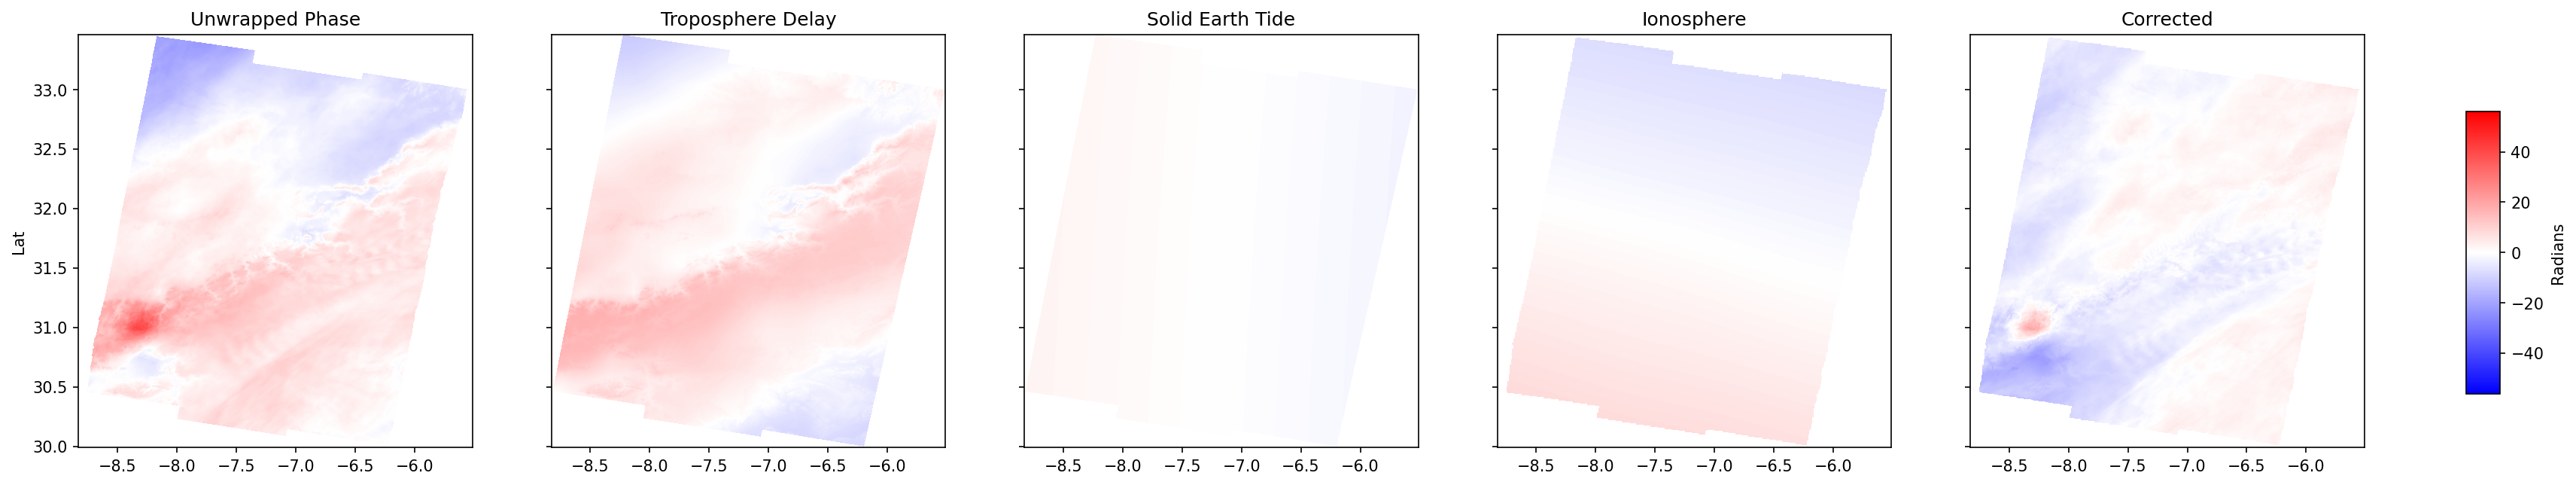

In [13]:
fig, axs = plt.subplots(1, 5, 
                        dpi=150, 
                        sharey=True, 
                        sharex=True, 
                        figsize=(30, 10))
cmap='bwr'

k = 1
unw_ref = unws_ref[k]
ion_ref = ions_ref[k]
set_ref = sets_ref[k]
tro_ref = tros_ref[k]
p = unw_ps[k]

out = show(unw_ref, transform=p['transform'], ax=axs[0], vmin=-v, vmax=v, cmap=cmap)
axs[0].set_ylabel('Lat')
axs[0].set_title('Unwrapped Phase')


show(tro_ref, transform=p['transform'], ax=axs[1], vmin=-v, vmax=v, cmap=cmap)
axs[1].set_title('Troposphere Delay')

show(set_ref, transform=p['transform'], ax=axs[2], vmin=-v, vmax=v, cmap=cmap)
axs[2].set_title('Solid Earth Tide')

show(ion_ref, transform=p['transform'], ax=axs[3], vmin=-v, vmax=v, cmap=cmap)
axs[3].set_title('Ionosphere')

corr = tro_ref + set_ref  + ion_ref
show(unw_ref - corr, transform=p['transform'], ax=axs[4], vmin=-v, vmax=v, cmap=cmap)
axs[4].set_title('Corrected')

im = out.get_images()[0]
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.36, 0.01, 0.25])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('Radians')


# All dates

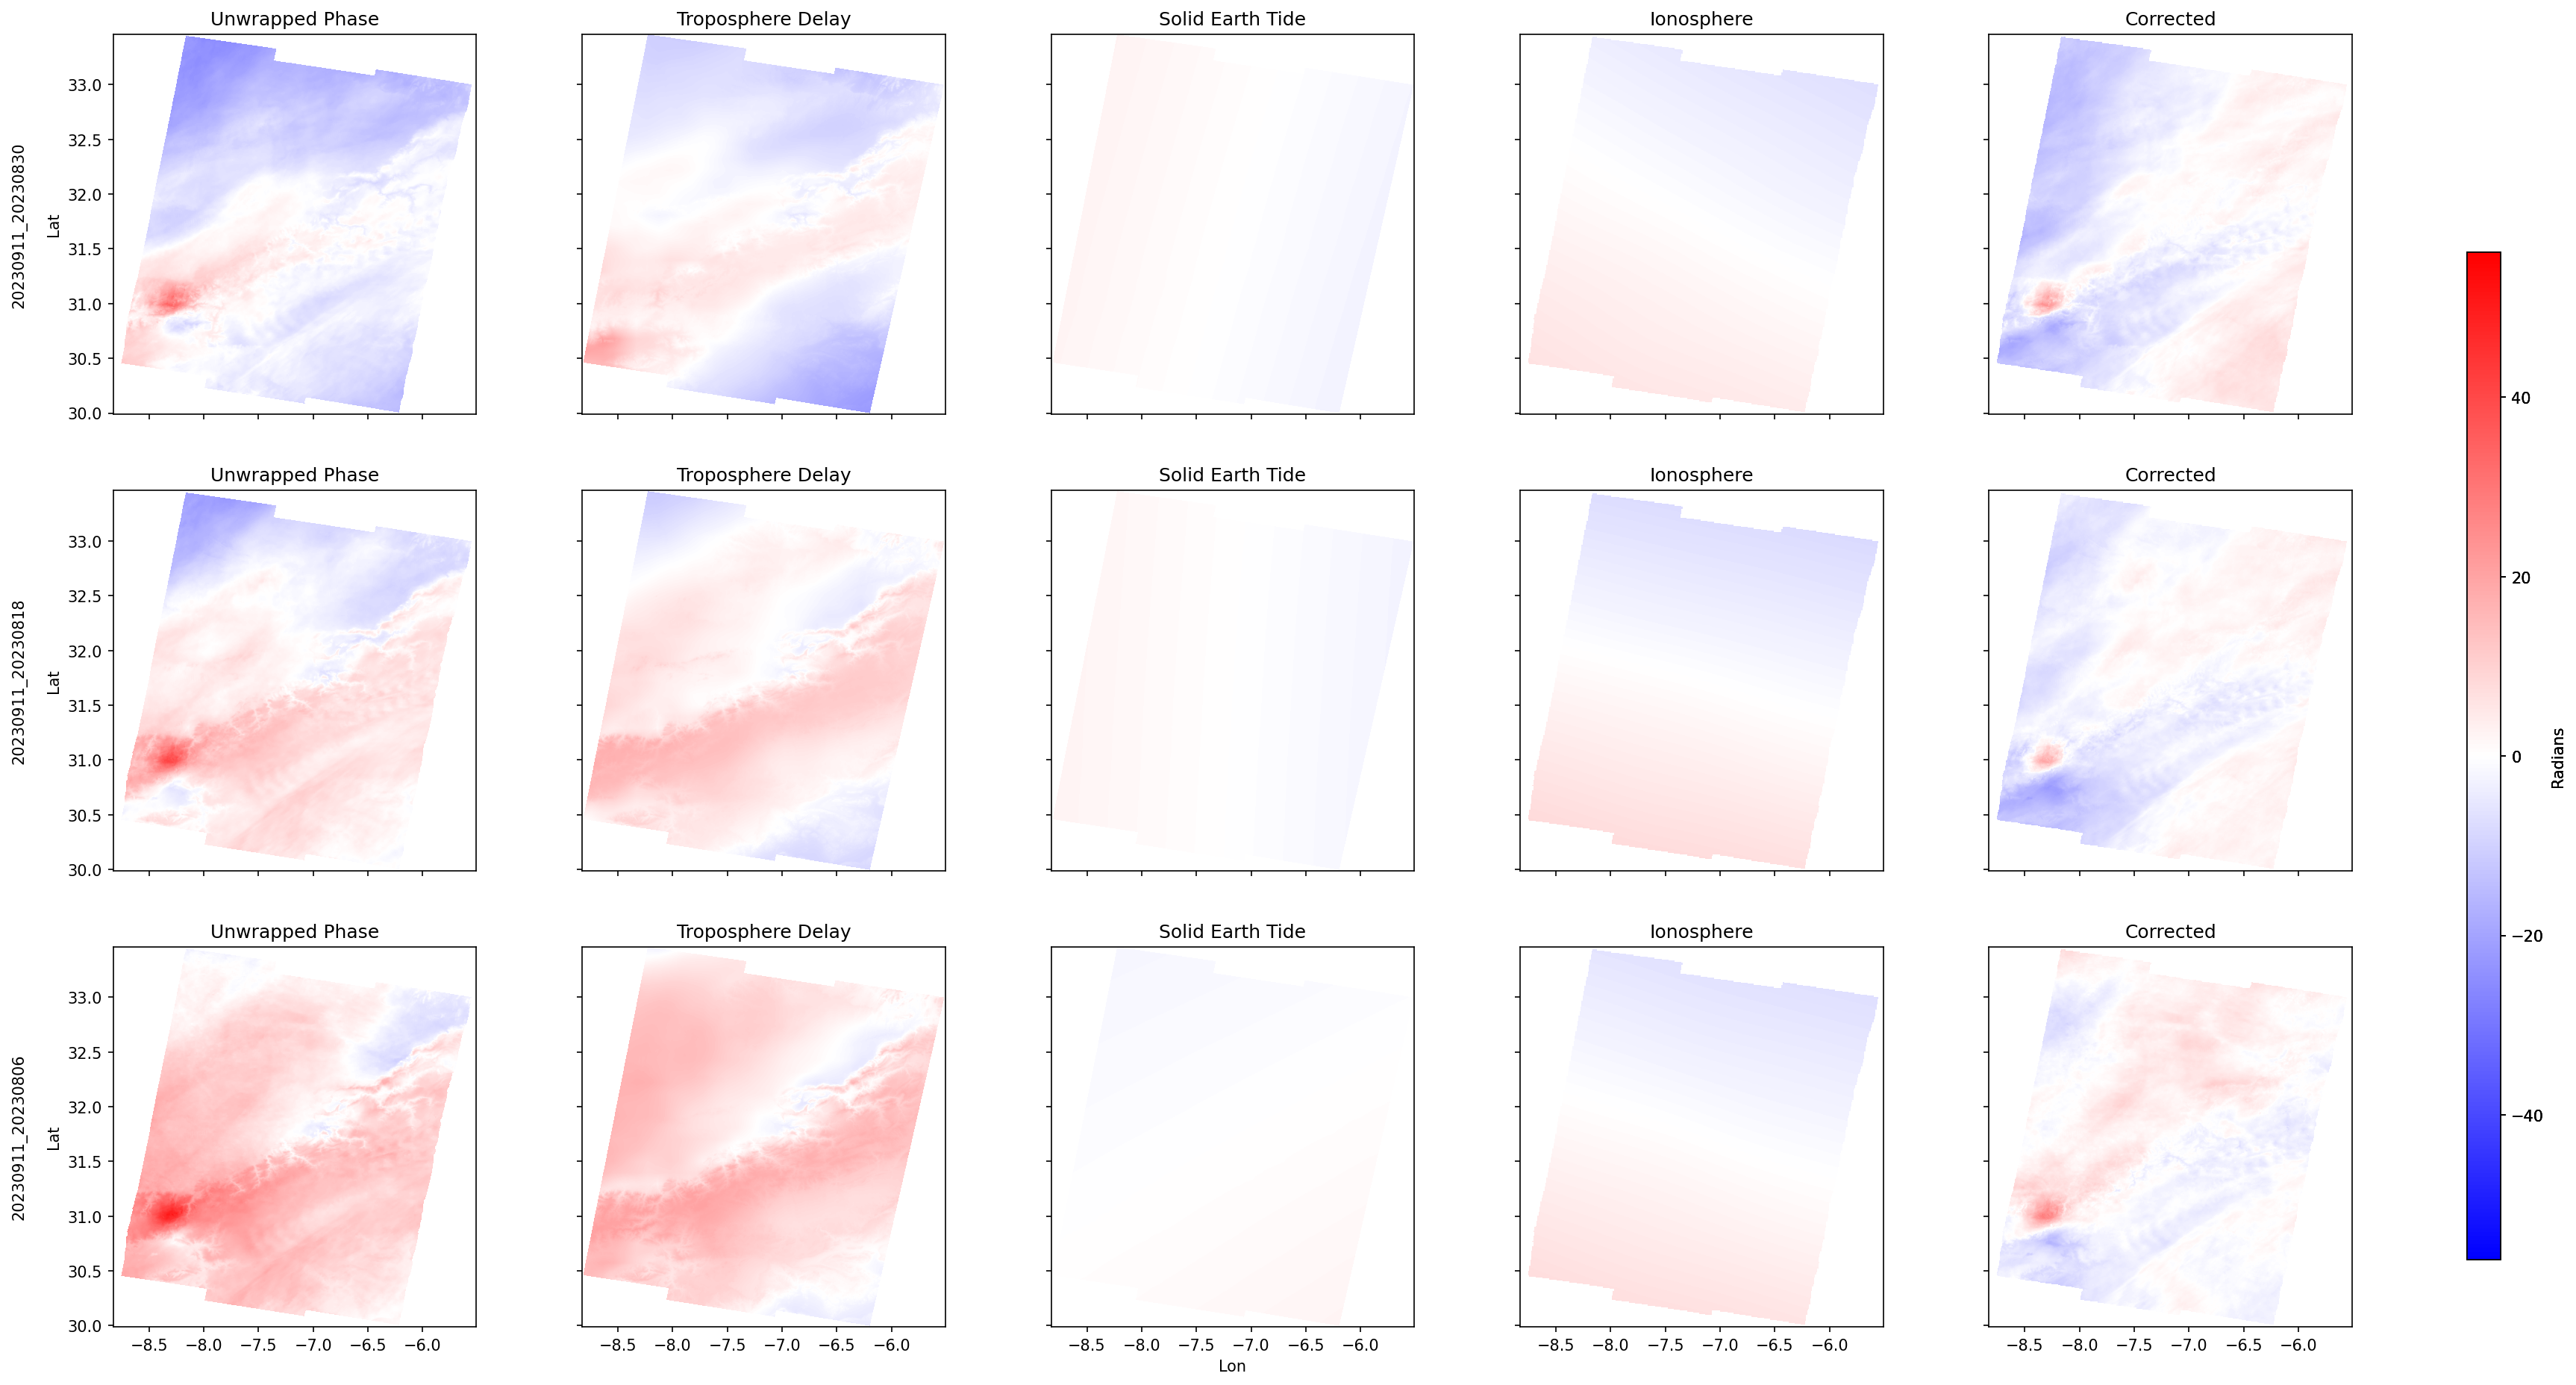

In [14]:
fig, axs = plt.subplots(len(unw_vrts), 5, 
                        dpi=150, 
                        sharey=True, 
                        sharex=True, 
                        figsize=(30, 15))
cmap='bwr'

for k in range(len(unw_vrts)):
    unw_ref = unws_ref[k]
    ion_ref = ions_ref[k]
    set_ref = sets_ref[k]
    tro_ref = tros_ref[k]
    p = unw_ps[k]

    date_pair_str = unw_vrts[k].stem
    out = show(unw_ref, transform=p['transform'], ax=axs[k, 0], vmin=-v, vmax=v, cmap=cmap)
    axs[k, 0].set_ylabel(date_pair_str + '\n' + '\n' + 'Lat')
    axs[k, 0].set_title('Unwrapped Phase')
    
    
    show(tro_ref, transform=p['transform'], ax=axs[k, 1], vmin=-v, vmax=v, cmap=cmap)
    axs[k, 1].set_title('Troposphere Delay')
    
    show(set_ref, transform=p['transform'], ax=axs[k, 2], vmin=-v, vmax=v, cmap=cmap)
    axs[k, 2].set_title('Solid Earth Tide')
    if k == (len(unw_vrts) - 1):
        axs[k, 2].set_xlabel('Lon')

    show(ion_ref, transform=p['transform'], ax=axs[k, 3], vmin=-v, vmax=v, cmap=cmap)
    axs[k, 3].set_title('Ionosphere')
    
    corr = tro_ref + set_ref + ion_ref
    show(unw_ref - corr, transform=p['transform'], ax=axs[k, 4], vmin=-v, vmax=v, cmap=cmap)
    axs[k, 4].set_title('Corrected')
    
    im = out.get_images()[0]
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.83, 0.15, 0.01, 0.6])
    fig.colorbar(im, cax=cbar_ax)
    cbar_ax.set_ylabel('Radians')